## packages install

In [1]:
# !pip3 install torch torchvision torchaudio --extra-index-url https: // download.pytorch.org / whl / cpu
# !pip install -U matplotlib

Defaulting to user installation because normal site-packages is not writeable
ERROR: Directory '//' is not installable. Neither 'setup.py' nor 'pyproject.toml' found.
Defaulting to user installation because normal site-packages is not writeable


## imports

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as functional
import torchvision.utils
from torch import tensor

from code.src.prune.el2n import get_prune_idx, get_el2n_scores
from code.src.utils.common import get_model_resnet18_cifar10, get_loader, create_saved_data_dir, get_device, save
from code.src.utils.dataset import get_cifar10
from code.src.utils.plot import plot_prune_example, compare_models_losses
from code.src.utils.train import train

## globals

In [3]:
NUM_CLASSES = 10
BATCH_SIZE = 5
NUM_TRAIN = 30
NUM_VALID = 20
NUM_TEST = 20
EPOCHS = 1
ENSEMBLE_SIZE = 1

DEVICE = get_device()
PATH_MODELS_SAVE = create_saved_data_dir(os.path.join(os.path.abspath(''), 'research', 'el2n_resnet18_cifar10.ipynb'))

CUDA is not available.  Training on CPU...


## data loaders, models


In [6]:
data_train, data_test = get_cifar10(os.path.abspath(os.path.join('../../../', 'datasets')))

loader_train = get_loader(data_train, np.arange(NUM_TRAIN), BATCH_SIZE)
loader_valid = get_loader(data_train, np.arange(NUM_TRAIN, NUM_VALID + NUM_TRAIN), BATCH_SIZE)
loader_test = get_loader(data_test, np.arange(NUM_TEST), BATCH_SIZE)

idx = np.arange(NUM_TRAIN)
# create loader with no shuffling
loader_train_ordered = get_loader(data_train, idx, BATCH_SIZE, shuffle=False)
Y_train = tensor(data_train.targets)[idx]

ensemble = [get_model_resnet18_cifar10() for _ in range(ENSEMBLE_SIZE)]
ensemble_softmax = torch.empty((len(ensemble), NUM_TRAIN, NUM_CLASSES))
ensemble_pred = torch.empty((NUM_TRAIN, len(ensemble)), dtype=torch.bool)

Files already downloaded and verified
Files already downloaded and verified


## train the ensemble

In [7]:
print()
for i, (model, criterion, optimizer) in enumerate(ensemble):
    print(f'------------   model {i}   -------------------')
    path = PATH_MODELS_SAVE(f'resnet18_{i}')
    train(model, loader_train, loader_valid, loader_test, criterion, optimizer, 2, NUM_CLASSES, DEVICE,
          verbose=True, save_path=path)

    model.eval()
    for batch_idx, (X, y) in enumerate(loader_train_ordered):
        X, y = X.to(DEVICE), y.to(DEVICE)
        pred = model(X)
        idx = np.arange(pred.shape[0]) * batch_idx
        ensemble_softmax[i, idx] = functional.softmax(pred, dim=1).clone().detach().cpu()
        ensemble_pred[idx, i] = torch.Tensor(torch.max(pred, 1)[1].type(torch.int8) == y).clone().detach().cpu()

ensemble_pred_sum = torch.sum(ensemble_pred, dim=1)
ensemble_var = ensemble_softmax.var(dim=0)


------------   model 0   -------------------
Epoch: 0 Training: Loss: 0.485577 Acc: 0.033333  Validation Loss: 0.477348 Acc: 0.050000
Validation loss decreased (inf --> 0.477348).  Saving model to /home/bb/Documents/Data-pruning/code/models_data/el2n_resnet18_cifar10/resnet18_0
Epoch: 1 Training: Loss: 0.473113 Acc: 0.033333  Validation Loss: 0.475994 Acc: 0.050000
Validation loss decreased (0.477348 --> 0.475994).  Saving model to /home/bb/Documents/Data-pruning/code/models_data/el2n_resnet18_cifar10/resnet18_0
Test Loss: 0.466322
Accuracy: 0.0


## Plot histogram of number of models that have right prediction per training example

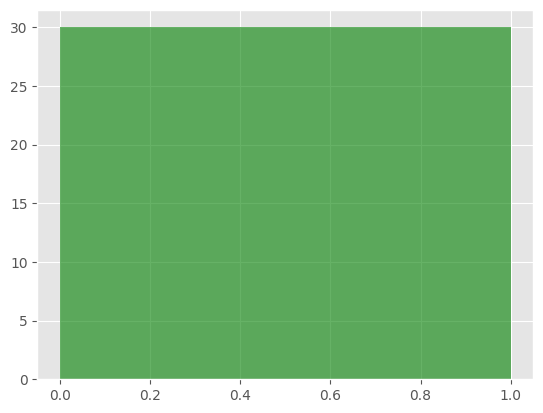

In [8]:
plt.style.use('ggplot')
plt.hist(ensemble_pred_sum, bins=len(ensemble), facecolor='g', alpha=0.6)
plt.show()

## Plot histogram of EL2N scores to 10 bins

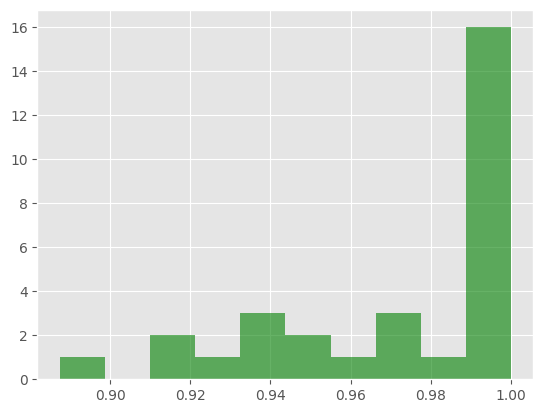

In [9]:
el2n_scores = get_el2n_scores(Y_train, ensemble_softmax)
plt.hist(el2n_scores, bins=len(data_train.classes), facecolor='g', alpha=0.6)
plt.show()

## Plot the hardest/easiest examples according to EL2N

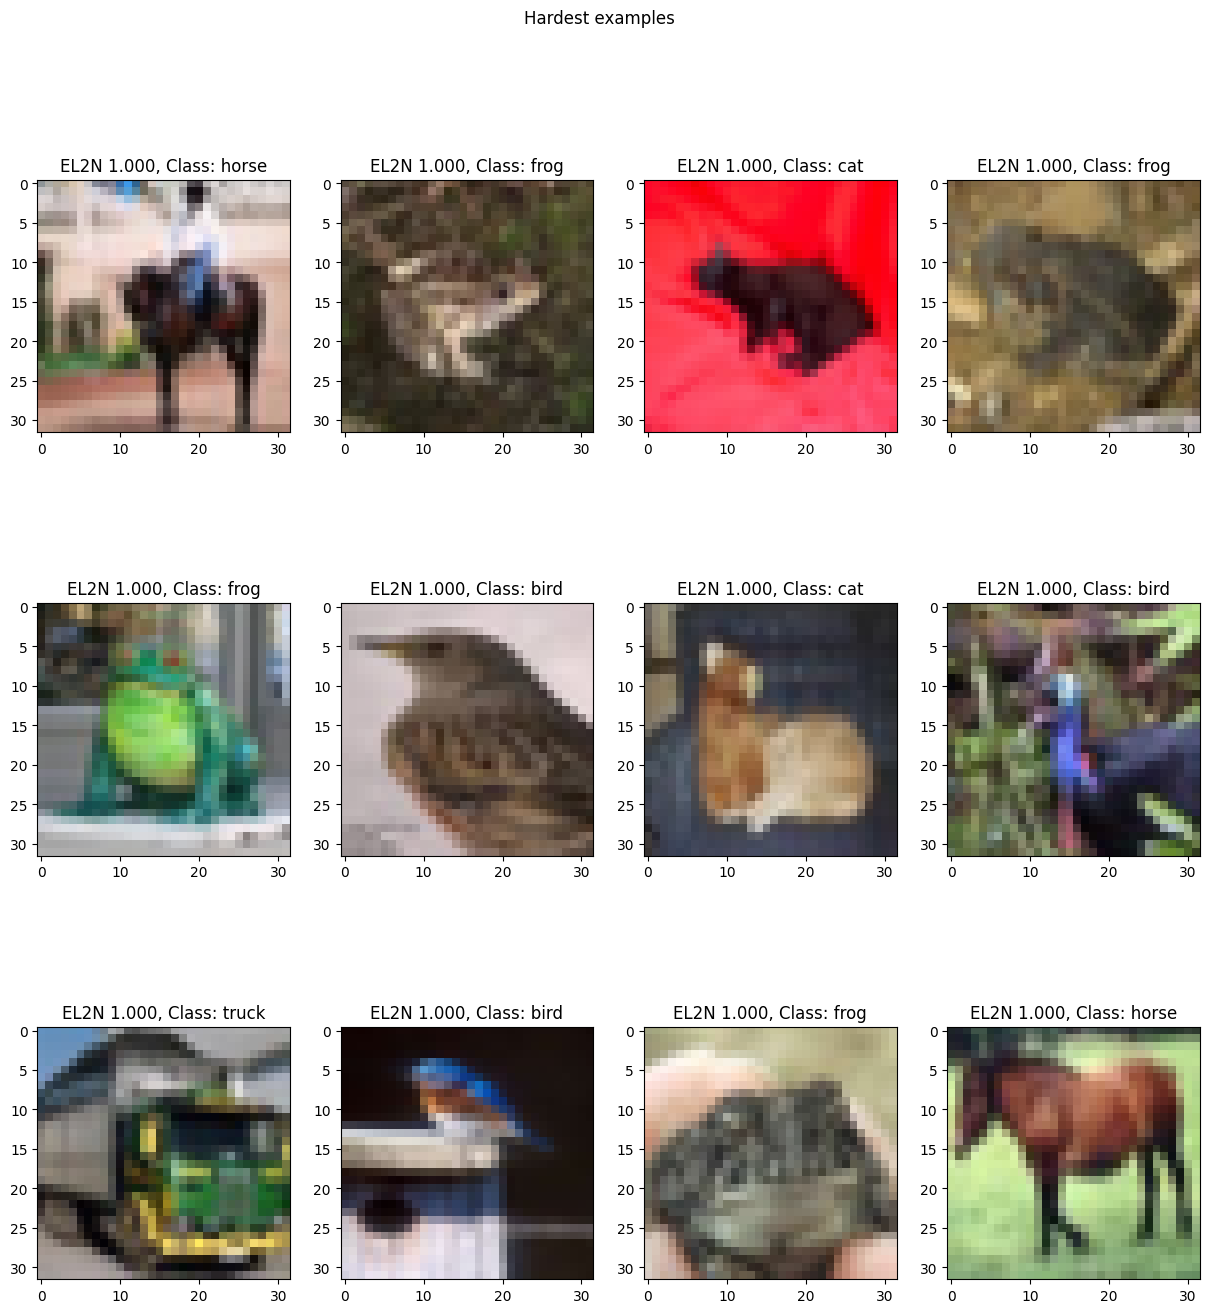

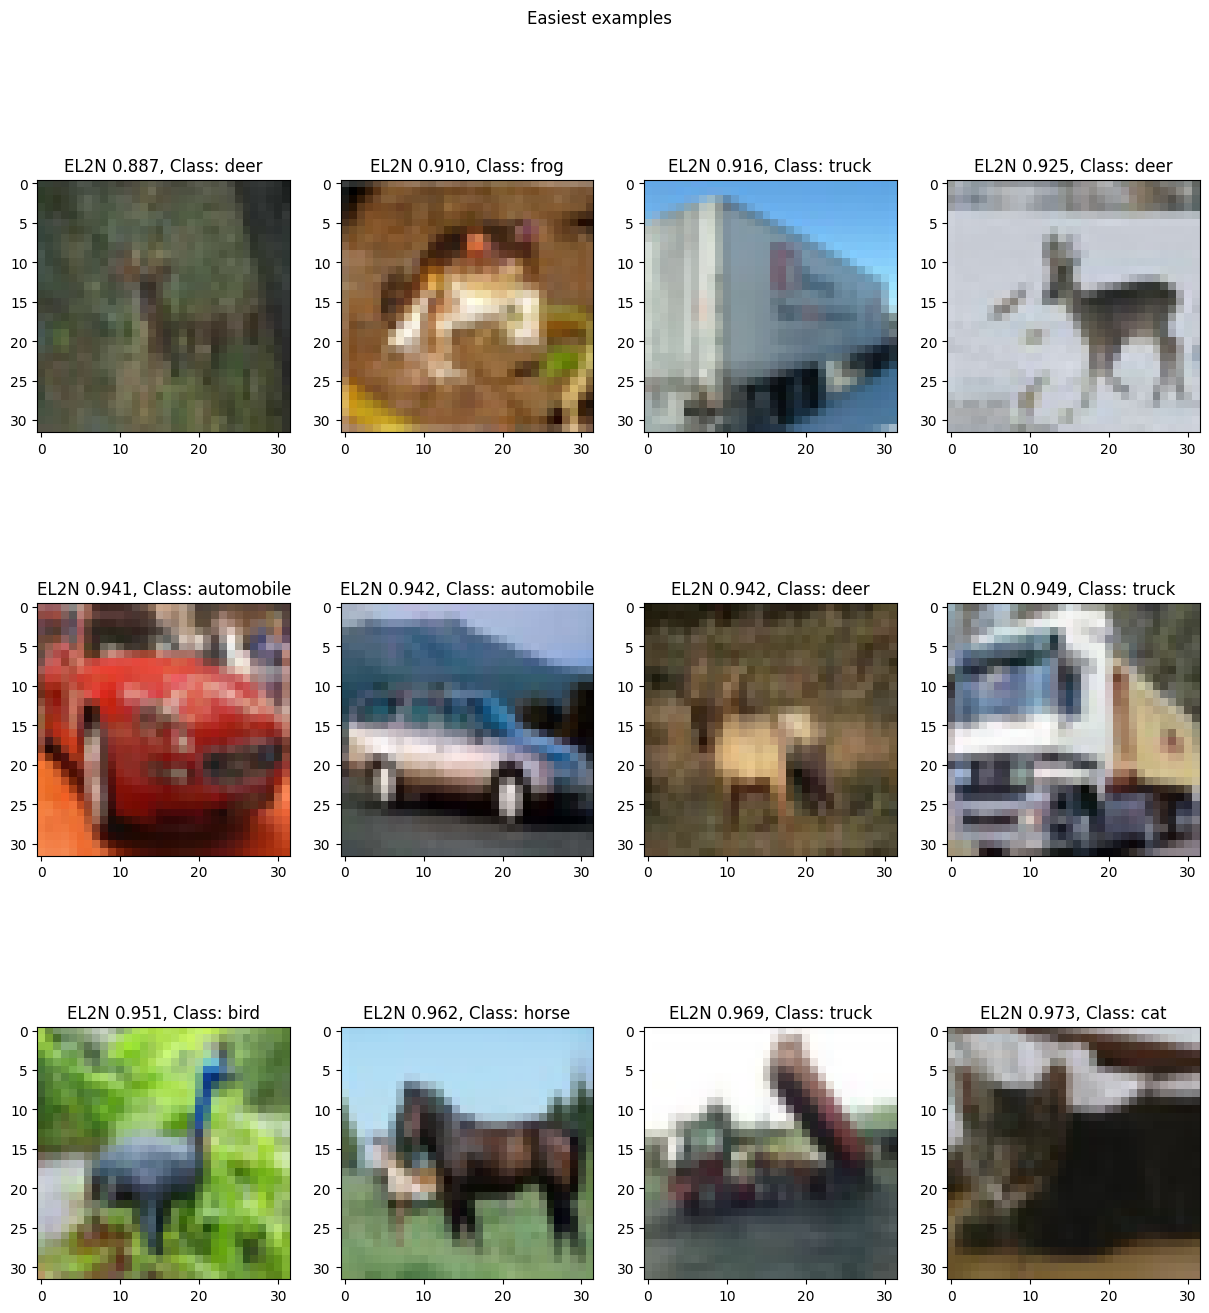

In [10]:
data_train_raw = torchvision.datasets.CIFAR10(os.path.abspath(r'../../../datasets'), train=True)
plot_prune_example(data_train_raw, el2n_scores, hardest=True, prune_method_name='EL2N', random=False)
plot_prune_example(data_train_raw, el2n_scores, hardest=False, prune_method_name='EL2N', random=False)

## train 2 models: with/without prune and compare the result


run model with prune
Epoch: 0 Training: Loss: 0.507983 Acc: 0.200000  Validation Loss: 0.460567 Acc: 0.100000
Validation loss decreased (inf --> 0.460567).  Saving model to /home/bb/Documents/Data-pruning/code/models_data/el2n_resnet18_cifar10/resnet18_prune
Test Loss: 0.460118
Accuracy: 0.20000000298023224

run model without prune
Epoch: 0 Training: Loss: 0.473308 Acc: 0.066667  Validation Loss: 0.461072 Acc: 0.100000
Validation loss decreased (inf --> 0.461072).  Saving model to /home/bb/Documents/Data-pruning/code/models_data/el2n_resnet18_cifar10/resnet18_no_prune
Test Loss: 0.462533
Accuracy: 0.15000000596046448


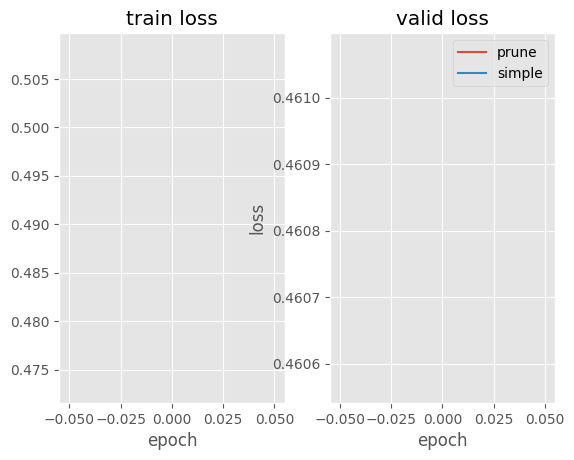

In [12]:
idx_to_keep = get_prune_idx(Y_train, ensemble_softmax, .5)

# train model with prune
print("\nrun model with prune")
loader_train_prune = get_loader(data_train, idx_to_keep, BATCH_SIZE, True)
model_prune, criterion_prune, optimizer_prune = get_model_resnet18_cifar10()
res_train_p, res_valid_p, _ =
train(model_prune, loader_train_prune, loader_valid, loader_test, criterion_prune, optimizer_prune, EPOCHS,
      NUM_CLASSES, DEVICE, verbose=True, save_path=PATH_MODELS_SAVE('resnet18_prune'))
scores_train_p, pred_train_p, loss_train_p, acc_train_p = res_train_p
scores_valid_p, pred_valid_p, loss_valid_p, acc_valid_p = res_valid_p

# train model without prune
print("\nrun model without prune")
model_simple, criterion_simple, optimizer_simple = get_model_resnet18_cifar10()
res_train, res_valid, _ = train(model_simple, loader_train, loader_valid, loader_test, criterion_simple,
                                optimizer_simple, EPOCHS, NUM_CLASSES, DEVICE, verbose=True,
                                save_path=PATH_MODELS_SAVE('resnet18_no_prune'))
scores_train, pred_train, loss_train, acc_train = res_train
scores_valid, pred_valid, loss_valid, acc_valid = res_valid

# load: model.load_state_dict(torch.load(PATH))
save(PATH_MODELS_SAVE(''), ensemble_pred=ensemble_pred, ensemble_pred_sum=ensemble_pred_sum,
     ensemble_softmax=ensemble_softmax, ensemble_var=ensemble_var, el2n_scores=el2n_scores,
     idx_to_keep=idx_to_keep, scores_train_prune=scores_train_prune, pred_train_prune=pred_train_prune,
     loss_train_prune=loss_train_prune, acc_train_prune=acc_train_prune, scores_valid_prune=scores_valid_prune,
     pred_valid_prune=pred_valid_prune, loss_valid_prune=loss_valid_prune, acc_valid_prune=acc_valid_prune)

compare_models_losses(loss_train, loss_train_p, loss_valid, loss_valid_p)